# 10주차 day5 신경망 실습 과제

MNIST데이터 MLP

## 1번. 수행 및 이해

In [1]:
import torch
import numpy as np
from torchvision import datasets
import torchvision.transforms as transforms
import os

torch.manual_seed(123)

c:\Users\minki\miniconda3\envs\dl_venv\lib\site-packages\requests\__init__.py:102: RequestsDependencyWarning: urllib3 (1.26.14) or chardet (5.1.0)/charset_normalizer (2.0.12) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({})/charset_normalizer ({}) doesn't match a supported "


In [2]:
# num_workes는 일종의 하이퍼 파라미터로 Dataloader에서 데이터를 불러올 때 쓰이는 cpu의 논리프로세서 개수
# GPU로 데이터를 넘겨주는데 사용. 너무 적으면 효율이 안좋고 너무 많으면 데이터 전송에 많은 프로세스가 사용되므로 다른 성능이 하락
# 보통 4 * GPU개수 / default : 0 이며 0은 메인 프로세스를 사용함
num_workers = 0

# how many samples per batch to load
batch_size = 32

# convert data to torch.FloatTensor
transform = transforms.ToTensor()

# choose the training and test datasets
train_data = datasets.MNIST(root='data', train=True,
                                   download=True, transform=transform)
test_data = datasets.MNIST(root='data', train=False,
                                  download=True, transform=transform)


# prepare data loaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
    num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, 
    num_workers=num_workers)

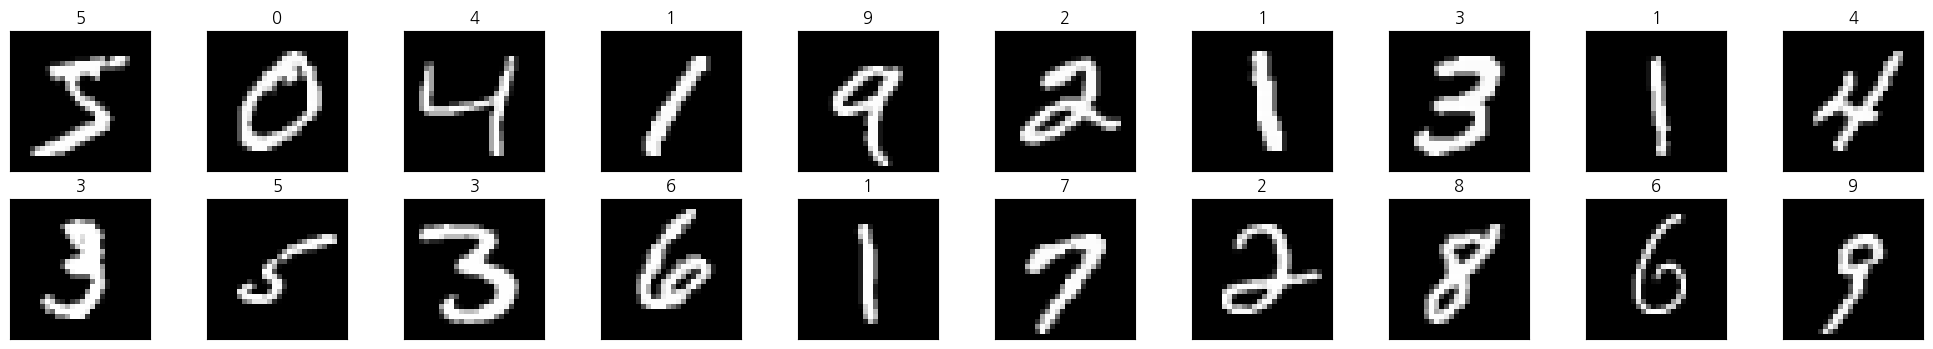

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline
    
# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = next(dataiter)
images = images.numpy()

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20//2, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    # print out the correct label for each image
    # .item() gets the value contained in a Tensor
    ax.set_title(str(labels[idx].item()))

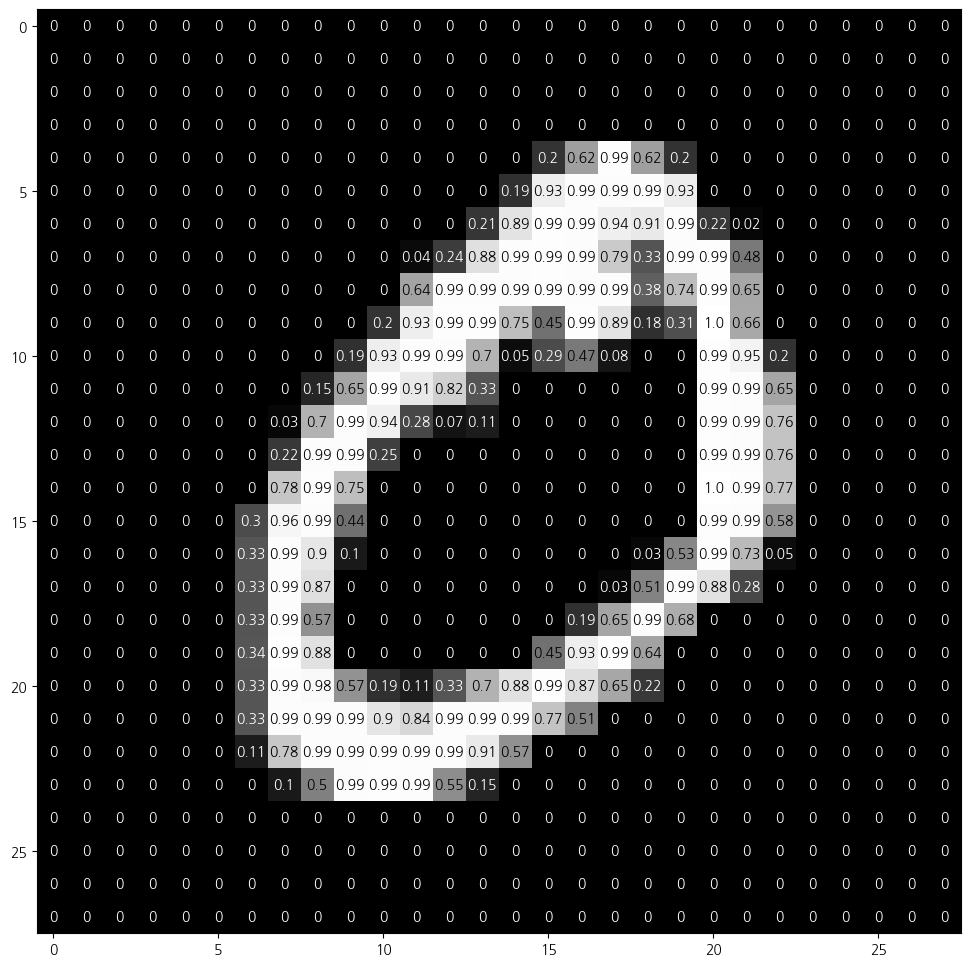

In [4]:
img = np.squeeze(images[1])

fig = plt.figure(figsize = (12,12)) 
ax = fig.add_subplot(111)
ax.imshow(img, cmap='gray')
width, height = img.shape
thresh = img.max()/2.5
for x in range(width):
    for y in range(height):
        val = round(img[x][y],2) if img[x][y] !=0 else 0
        ax.annotate(str(val), xy=(y,x),
                    horizontalalignment='center',
                    verticalalignment='center',
                    color='white' if img[x][y]<thresh else 'black')

In [5]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

In [6]:
import torch.nn as nn
import torch.nn.functional as F

## Define the NN architecture
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 512)
        # linear layer (n_hidden -> 10)
        self.fc2 = nn.Linear(512, 10)


    def forward(self, x):
        # flatten image input
        x = x.view(-1, 28 * 28)
        # add hidden layer, with relu activation function
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# initialize the NN
model = Net()
print(model)

Net(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=10, bias=True)
)


모델의 파라미터 수 : 407,050 개

In [7]:
from torchsummary import summary
summary(model, input_size=(1, 28, 28),device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 512]         401,920
            Linear-2                   [-1, 10]           5,130
Total params: 407,050
Trainable params: 407,050
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 1.55
Estimated Total Size (MB): 1.56
----------------------------------------------------------------


In [8]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)

# number of epochs to train the model
n_epochs = 10  # suggest training between 10-50 epochs

model.train() # prep model for training

for epoch in range(n_epochs):
    # monitor training loss
    train_loss = 0.0
    
    ###################
    # train the model #
    ###################
    for data, target in train_loader:
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update running training loss
        train_loss += loss.item()*data.size(0)
        
    # print training statistics 
    # calculate average loss over an epoch
    train_loss = train_loss/len(train_loader.dataset)

    print('Epoch: {} \tTraining Loss: {:.6f}'.format(
        epoch+1, 
        train_loss
        ))

Epoch: 1 	Training Loss: 0.323305
Epoch: 2 	Training Loss: 0.144261
Epoch: 3 	Training Loss: 0.099376
Epoch: 4 	Training Loss: 0.075615
Epoch: 5 	Training Loss: 0.060282
Epoch: 6 	Training Loss: 0.049221
Epoch: 7 	Training Loss: 0.040753
Epoch: 8 	Training Loss: 0.034044
Epoch: 9 	Training Loss: 0.028598
Epoch: 10 	Training Loss: 0.024099


In [9]:
# initialize lists to monitor test loss and accuracy
test_loss = 0.0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

model.eval() # prep model for *evaluation*

for data, target in test_loader:
    # forward pass: compute predicted outputs by passing inputs to the model
    output = model(data)
    # calculate the loss
    loss = criterion(output, target)
    # update test loss 
    test_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)
    # compare predictions to true label
    correct = np.squeeze(pred.eq(target.data.view_as(pred)))
    # calculate test accuracy for each object class
    for i in range(len(target.data)):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1
    
        
# calculate and print avg test loss
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(10):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            str(i), 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (str(i)))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 0.068336

Test Accuracy of     0: 99% (972/980)
Test Accuracy of     1: 99% (1127/1135)
Test Accuracy of     2: 97% (1006/1032)
Test Accuracy of     3: 98% (990/1010)
Test Accuracy of     4: 98% (965/982)
Test Accuracy of     5: 98% (877/892)
Test Accuracy of     6: 97% (932/958)
Test Accuracy of     7: 95% (980/1028)
Test Accuracy of     8: 97% (947/974)
Test Accuracy of     9: 97% (983/1009)

Test Accuracy (Overall): 97% (9779/10000)


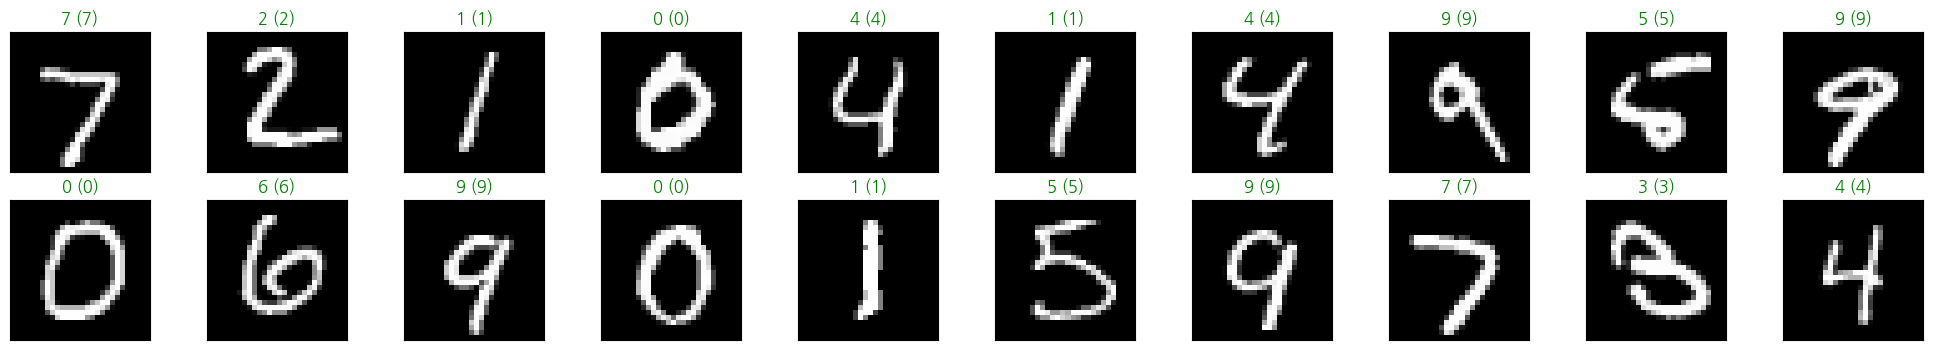

In [10]:
# obtain one batch of test images
dataiter = iter(test_loader)
images, labels = next(dataiter)

# get sample outputs
output = model(images)
# convert output probabilities to predicted class
_, preds = torch.max(output, 1)
# prep images for display
images = images.numpy()

# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20//2, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    ax.set_title("{} ({})".format(str(preds[idx].item()), str(labels[idx].item())),
                 color=("green" if preds[idx]==labels[idx] else "red"))

## 2. 모델 성능 향상 방법

0. train/valid/test 나누기
1. 적절한 epoch 수 조절
2. 하이퍼 파라미터 lr 조절
3. 데이터 증강(mixup test)
4. 모델 구조 변경(spinal net test)

In [11]:
import torch
import numpy as np
from torchvision import datasets
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import os

### Test1. 조기종료 + 스케줄러 사용

- baseline model 성능은 9779/10000이었음

In [47]:
from torch.utils.data import TensorDataset
num_workers = 0
batch_size = 32
valid_data_size = 10000

transform = transforms.ToTensor()
train_data = datasets.MNIST(root='data', train=True,
                                   download=True, transform=transform)
test_data = datasets.MNIST(root='data', train=False,
                                  download=True, transform=transform)

train_data, valid_data = torch.utils.data.random_split(train_data, [len(train_data) - valid_data_size, valid_data_size],generator=torch.Generator().manual_seed(123))

# Create the train_loader, valid_loader, and test_loader
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(valid_data, batch_size=batch_size, shuffle=False, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=False, num_workers=num_workers)
print(len(train_loader.dataset),len(valid_loader.dataset),len(test_loader.dataset))

50000 10000 10000


In [13]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

In [14]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 512)
        self.fc2 = nn.Linear(512, 10)


    def forward(self, x):
        x = x.view(-1, 28 * 28)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x
    
model = Net()
model.to(device)

Net(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=10, bias=True)
)

In [15]:
from torchsummary import summary
summary(model, input_size=(1, 28, 28),device=device.type)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 512]         401,920
            Linear-2                   [-1, 10]           5,130
Total params: 407,050
Trainable params: 407,050
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 1.55
Estimated Total Size (MB): 1.56
----------------------------------------------------------------


In [16]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer=optimizer,
                                        lr_lambda=lambda epoch: 0.95 ** epoch)
n_epochs = 100

train_loss_list , valid_loss_list = [] , []
best_score = float('inf')

model.train()
patience = 0
for epoch in range(n_epochs):
    train_loss = 0.0
    for data, target in train_loader:
        data , target = data.to(device) , target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()*data.size(0)
    scheduler.step()
    train_loss_list.append(train_loss/len(train_loader.dataset))

    # valid_data
    with torch.no_grad():
        valid_loss = 0.0
        for data, target in valid_loader:
            data , target = data.to(device) , target.to(device)
            output = model(data)
            loss = criterion(output, target)
            valid_loss += loss.item()*data.size(0)
        valid_loss_list.append(valid_loss/len(valid_loader.dataset))
    
        print('Epoch: {} \tTraining Loss: {:.6f} \t valid Loss: {:.6f}'.format(epoch+1, train_loss_list[-1],valid_loss_list[-1]))
        
    if valid_loss_list[-1] < best_score:
        best_score = valid_loss_list[-1]
        torch.save(model.state_dict(), os.path.join('./model_data/', '{}.pth'.format('best')))
        patience = 0
    else:
        patience += 1
        if patience == 5:
            break


Epoch: 1 	Training Loss: 0.356727 alid Loss: 0.225806
Epoch: 2 	Training Loss: 0.162932 alid Loss: 0.139735
Epoch: 3 	Training Loss: 0.114759 alid Loss: 0.112986
Epoch: 4 	Training Loss: 0.088716 alid Loss: 0.096933
Epoch: 5 	Training Loss: 0.071559 alid Loss: 0.087261
Epoch: 6 	Training Loss: 0.059751 alid Loss: 0.084051
Epoch: 7 	Training Loss: 0.050593 alid Loss: 0.084907
Epoch: 8 	Training Loss: 0.043868 alid Loss: 0.073316
Epoch: 9 	Training Loss: 0.038107 alid Loss: 0.071742
Epoch: 10 	Training Loss: 0.033139 alid Loss: 0.072765
Epoch: 11 	Training Loss: 0.029546 alid Loss: 0.067393
Epoch: 12 	Training Loss: 0.026198 alid Loss: 0.066822
Epoch: 13 	Training Loss: 0.023608 alid Loss: 0.066142
Epoch: 14 	Training Loss: 0.021294 alid Loss: 0.066427
Epoch: 15 	Training Loss: 0.019442 alid Loss: 0.065737
Epoch: 16 	Training Loss: 0.017770 alid Loss: 0.065815
Epoch: 17 	Training Loss: 0.016531 alid Loss: 0.065924
Epoch: 18 	Training Loss: 0.015244 alid Loss: 0.064456
E

In [17]:
# test_Data 로 성능평가
model.load_state_dict(torch.load(os.path.join('./model_data/', '{}.pth'.format('best'))))

test_loss = 0.0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

model.eval()

for data, target in test_loader:
    data, target = data.to(device), target.to(device)
    output = model(data)
    loss = criterion(output, target)
    test_loss += loss.item()*data.size(0)
    _, pred = torch.max(output, 1)
    correct = np.squeeze(pred.eq(target.data.view_as(pred)))
    for i in range(len(target.data)):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1
    
        
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(10):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            str(i), 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (str(i)))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 0.061158

Test Accuracy of     0: 98% (969/980)
Test Accuracy of     1: 99% (1124/1135)
Test Accuracy of     2: 97% (1010/1032)
Test Accuracy of     3: 98% (991/1010)
Test Accuracy of     4: 98% (964/982)
Test Accuracy of     5: 97% (871/892)
Test Accuracy of     6: 98% (943/958)
Test Accuracy of     7: 97% (1007/1028)
Test Accuracy of     8: 97% (951/974)
Test Accuracy of     9: 97% (982/1009)

Test Accuracy (Overall): 98% (9812/10000)


Test1은 98.12%로 baseline모델보다 33개 더 맞춤

## Test2&3. dropout + optimizer

In [42]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 512)
        self.fc2 = nn.Linear(512, 10)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.4)

    def forward(self, x):
        x = x.view(-1, 28 * 28)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x
    
model = Net()
model.to(device)

Net(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=10, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.4, inplace=False)
)

In [43]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer=optimizer,
                                        lr_lambda=lambda epoch: 0.95 ** epoch)
n_epochs = 100

train_loss_list , valid_loss_list = [] , []
best_score = float('inf')

model.train()
patience = 0
for epoch in range(n_epochs):
    train_loss = 0.0
    for data, target in train_loader:
        data , target = data.to(device) , target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()*data.size(0)
    scheduler.step()
    train_loss_list.append(train_loss/len(train_loader.dataset))

    # valid_data
    with torch.no_grad():
        valid_loss = 0.0
        for data, target in valid_loader:
            data , target = data.to(device) , target.to(device)
            output = model(data)
            loss = criterion(output, target)
            valid_loss += loss.item()*data.size(0)
        valid_loss_list.append(valid_loss/len(valid_loader.dataset))
    
        print('Epoch: {} \tTraining Loss: {:.6f} \t valid Loss: {:.6f}'.format(epoch+1, train_loss_list[-1],valid_loss_list[-1]))
        
    if valid_loss_list[-1] < best_score:
        best_score = valid_loss_list[-1]
        torch.save(model.state_dict(), os.path.join('./model_data/', '{}.pth'.format('best')))
        patience = 0
    else:
        patience += 1
        if patience == 5:
            break


Epoch: 1 	Training Loss: 0.288570 	 valid Loss: 0.169425
Epoch: 2 	Training Loss: 0.135727 	 valid Loss: 0.131336
Epoch: 3 	Training Loss: 0.098412 	 valid Loss: 0.113880
Epoch: 4 	Training Loss: 0.077065 	 valid Loss: 0.097536
Epoch: 5 	Training Loss: 0.064950 	 valid Loss: 0.099726
Epoch: 6 	Training Loss: 0.055697 	 valid Loss: 0.105947
Epoch: 7 	Training Loss: 0.046207 	 valid Loss: 0.094419
Epoch: 8 	Training Loss: 0.039588 	 valid Loss: 0.092647
Epoch: 9 	Training Loss: 0.034907 	 valid Loss: 0.094128
Epoch: 10 	Training Loss: 0.030084 	 valid Loss: 0.091819
Epoch: 11 	Training Loss: 0.028598 	 valid Loss: 0.090946
Epoch: 12 	Training Loss: 0.023915 	 valid Loss: 0.092131
Epoch: 13 	Training Loss: 0.021694 	 valid Loss: 0.096511
Epoch: 14 	Training Loss: 0.016578 	 valid Loss: 0.096930
Epoch: 15 	Training Loss: 0.018884 	 valid Loss: 0.083444
Epoch: 16 	Training Loss: 0.014779 	 valid Loss: 0.086493
Epoch: 17 	Training Loss: 0.013984 	 valid Loss: 0.095139
Epoch: 18 	Training Los

In [44]:
# test_Data 로 성능평가
model.load_state_dict(torch.load(os.path.join('./model_data/', '{}.pth'.format('best'))))

test_loss = 0.0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

model.eval()

for data, target in test_loader:
    data, target = data.to(device), target.to(device)
    output = model(data)
    loss = criterion(output, target)
    test_loss += loss.item()*data.size(0)
    _, pred = torch.max(output, 1)
    correct = np.squeeze(pred.eq(target.data.view_as(pred)))
    for i in range(len(target.data)):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1
    
        
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(10):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            str(i), 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (str(i)))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 0.064566

Test Accuracy of     0: 98% (970/980)
Test Accuracy of     1: 99% (1127/1135)
Test Accuracy of     2: 98% (1014/1032)
Test Accuracy of     3: 97% (985/1010)
Test Accuracy of     4: 97% (961/982)
Test Accuracy of     5: 97% (869/892)
Test Accuracy of     6: 98% (944/958)
Test Accuracy of     7: 98% (1010/1028)
Test Accuracy of     8: 97% (954/974)
Test Accuracy of     9: 97% (987/1009)

Test Accuracy (Overall): 98% (9821/10000)


## Test4. 데이터 증강(mix up)

In [53]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 512)
        self.fc2 = nn.Linear(512, 10)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.4)

    def forward(self, x):
        x = x.view(-1, 28 * 28)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x
    
model = Net()
model.to(device)

Net(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=10, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.4, inplace=False)
)

In [ ]:
from torchsummary import summary
summary(model, input_size=(1, 28, 28),device=device.type)

In [54]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer=optimizer,
                                        lr_lambda=lambda epoch: 0.95 ** epoch)
n_epochs = 100

train_loss_list , valid_loss_list = [] , []
best_score = float('inf')

model.train()
patience = 0
for epoch in range(n_epochs):
    train_loss = 0.0
    for data, target in train_loader:
        data , target = data.to(device) , target.to(device)

        # min-up
        lam = np.random.beta(0.5,0.5)
        indices = torch.randperm(len(data))
        mixed_data = lam * data + (1 - lam) * data[indices]
        output = model(mixed_data)
        loss = lam * criterion(output, target) + (1-lam) * criterion(output, target[indices])

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item()*data.size(0)
    scheduler.step()
    train_loss_list.append(train_loss/len(train_loader.dataset))

    # valid_data
    with torch.no_grad():
        valid_loss = 0.0
        for data, target in valid_loader:
            data , target = data.to(device) , target.to(device)
            output = model(data)
            loss = criterion(output, target)
            valid_loss += loss.item()*data.size(0)
        valid_loss_list.append(valid_loss/len(valid_loader.dataset))
    
        print('Epoch: {} \tTraining Loss: {:.6f} \t valid Loss: {:.6f}'.format(epoch+1, train_loss_list[-1],valid_loss_list[-1]))
        
    if valid_loss_list[-1] < best_score:
        best_score = valid_loss_list[-1]
        torch.save(model.state_dict(), os.path.join('./model_data/', '{}.pth'.format('best')))
        patience = 0
    else:
        patience += 1
        if patience == 5:
            break


Epoch: 1 	Training Loss: 0.955129 	 valid Loss: 0.305410
Epoch: 2 	Training Loss: 0.779020 	 valid Loss: 0.249334
Epoch: 3 	Training Loss: 0.761219 	 valid Loss: 0.206664
Epoch: 4 	Training Loss: 0.723015 	 valid Loss: 0.191144
Epoch: 5 	Training Loss: 0.713814 	 valid Loss: 0.172078
Epoch: 6 	Training Loss: 0.707400 	 valid Loss: 0.162589
Epoch: 7 	Training Loss: 0.685284 	 valid Loss: 0.164782
Epoch: 8 	Training Loss: 0.678216 	 valid Loss: 0.155842
Epoch: 9 	Training Loss: 0.675769 	 valid Loss: 0.152186
Epoch: 10 	Training Loss: 0.655449 	 valid Loss: 0.146427
Epoch: 11 	Training Loss: 0.654530 	 valid Loss: 0.146458
Epoch: 12 	Training Loss: 0.656185 	 valid Loss: 0.142083
Epoch: 13 	Training Loss: 0.655726 	 valid Loss: 0.142319
Epoch: 14 	Training Loss: 0.660955 	 valid Loss: 0.136485
Epoch: 15 	Training Loss: 0.644613 	 valid Loss: 0.134707
Epoch: 16 	Training Loss: 0.656331 	 valid Loss: 0.135660
Epoch: 17 	Training Loss: 0.632124 	 valid Loss: 0.135071
Epoch: 18 	Training Los

In [56]:
# test_Data 로 성능평가
model.load_state_dict(torch.load(os.path.join('./model_data/', '{}.pth'.format('best'))))

test_loss = 0.0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

model.eval()

for data, target in test_loader:
    data, target = data.to(device), target.to(device)
    output = model(data)
    loss = criterion(output, target)
    test_loss += loss.item()*data.size(0)
    _, pred = torch.max(output, 1)
    correct = np.squeeze(pred.eq(target.data.view_as(pred)))
    for i in range(len(target.data)):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1
    
        
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(10):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            str(i), 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (str(i)))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 0.104436

Test Accuracy of     0: 99% (972/980)
Test Accuracy of     1: 99% (1129/1135)
Test Accuracy of     2: 97% (1006/1032)
Test Accuracy of     3: 98% (991/1010)
Test Accuracy of     4: 97% (961/982)
Test Accuracy of     5: 97% (870/892)
Test Accuracy of     6: 98% (939/958)
Test Accuracy of     7: 96% (996/1028)
Test Accuracy of     8: 95% (935/974)
Test Accuracy of     9: 96% (973/1009)

Test Accuracy (Overall): 97% (9772/10000)


## Test5. spinal net

base model과 비슷한 파라미터 수(407,050개)를 갖도록 설계

In [164]:
class Net(nn.Module):
    def __init__(self,feature_num,layer_width):
        super(Net, self).__init__()
        self.half_in_size = round(feature_num/2)
        self.layer_width = layer_width

        self.fc_spinal_layer1 = nn.Sequential(
            nn.Dropout(p = 0.4), 
            nn.Linear(self.half_in_size, layer_width),
            #nn.BatchNorm1d(layer_width), 
            nn.ReLU(inplace=True),)
        self.fc_spinal_layer2 = nn.Sequential(
            nn.Dropout(p = 0.4), 
            nn.Linear(self.half_in_size+layer_width, layer_width), 
            nn.ReLU(inplace=True),)
        self.fc_spinal_layer3 = nn.Sequential(
            nn.Dropout(p = 0.4), 
            nn.Linear(self.half_in_size+layer_width, layer_width),
            nn.ReLU(inplace=True),)
        self.fc_spinal_layer4 = nn.Sequential(
            nn.Dropout(p = 0.4), 
            nn.Linear(self.half_in_size+layer_width, layer_width),
            nn.ReLU(inplace=True),)
        self.fc_out = nn.Sequential(
            nn.Dropout(p = 0.4), 
            nn.Linear(layer_width*4, 10),)

    def forward(self, x):
        x = x.view(-1, 28 * 28)
        x1 = self.fc_spinal_layer1(x[:, 0:self.half_in_size])
        x2 = self.fc_spinal_layer2(torch.cat([ x[:,self.half_in_size:2*self.half_in_size], x1], dim=1))
        x3 = self.fc_spinal_layer3(torch.cat([ x[:,0:self.half_in_size], x2], dim=1))
        x4 = self.fc_spinal_layer4(torch.cat([ x[:,self.half_in_size:2*self.half_in_size], x3], dim=1))
        
        
        x = torch.cat([x1, x2, x3, x4], dim=1)
        x = self.fc_out(x)
        return x

In [165]:
from torchsummary import summary
model = Net(28*28,100)
model.to(device)
summary(model, input_size=(1, 28, 28),device='cpu')

RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cpu! (when checking argument for argument mat1 in method wrapper_CUDA_addmm)

In [92]:
from torchsummary import summary
model = Net(28*28,180)
model.to(device)
print()
summary(model, input_size=(1, 28, 28),device=device.type)


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Dropout-1                  [-1, 392]               0
            Linear-2                  [-1, 180]          70,740
              ReLU-3                  [-1, 180]               0
           Dropout-4                  [-1, 572]               0
            Linear-5                  [-1, 180]         103,140
              ReLU-6                  [-1, 180]               0
           Dropout-7                  [-1, 572]               0
            Linear-8                  [-1, 180]         103,140
              ReLU-9                  [-1, 180]               0
          Dropout-10                  [-1, 572]               0
           Linear-11                  [-1, 180]         103,140
             ReLU-12                  [-1, 180]               0
          Dropout-13                  [-1, 720]               0
           Linear-14                  

In [78]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer=optimizer,
                                        lr_lambda=lambda epoch: 0.95 ** epoch)
n_epochs = 100

train_loss_list , valid_loss_list = [] , []
best_score = float('inf')

model.train()
patience = 0
for epoch in range(n_epochs):
    train_loss = 0.0
    for data, target in train_loader:
        data , target = data.to(device) , target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()*data.size(0)
    scheduler.step()
    train_loss_list.append(train_loss/len(train_loader.dataset))

    # valid_data
    with torch.no_grad():
        valid_loss = 0.0
        for data, target in valid_loader:
            data , target = data.to(device) , target.to(device)
            output = model(data)
            loss = criterion(output, target)
            valid_loss += loss.item()*data.size(0)
        valid_loss_list.append(valid_loss/len(valid_loader.dataset))
    
        print('Epoch: {} \tTraining Loss: {:.6f} \t valid Loss: {:.6f}'.format(epoch+1, train_loss_list[-1],valid_loss_list[-1]))
        
    if valid_loss_list[-1] < best_score:
        best_score = valid_loss_list[-1]
        torch.save(model.state_dict(), os.path.join('./model_data/', '{}.pth'.format('best')))
        patience = 0
    else:
        patience += 1
        if patience == 5:
            break


Epoch: 1 	Training Loss: 0.455818 	 valid Loss: 0.273308
Epoch: 2 	Training Loss: 0.221421 	 valid Loss: 0.201230
Epoch: 3 	Training Loss: 0.173556 	 valid Loss: 0.165354
Epoch: 4 	Training Loss: 0.147945 	 valid Loss: 0.148384
Epoch: 5 	Training Loss: 0.133446 	 valid Loss: 0.142382
Epoch: 6 	Training Loss: 0.119070 	 valid Loss: 0.135195
Epoch: 7 	Training Loss: 0.110690 	 valid Loss: 0.118595
Epoch: 8 	Training Loss: 0.104103 	 valid Loss: 0.124056
Epoch: 9 	Training Loss: 0.098674 	 valid Loss: 0.110739
Epoch: 10 	Training Loss: 0.092432 	 valid Loss: 0.117888
Epoch: 11 	Training Loss: 0.091175 	 valid Loss: 0.113626
Epoch: 12 	Training Loss: 0.084956 	 valid Loss: 0.110963
Epoch: 13 	Training Loss: 0.080876 	 valid Loss: 0.111727
Epoch: 14 	Training Loss: 0.080244 	 valid Loss: 0.101740
Epoch: 15 	Training Loss: 0.079324 	 valid Loss: 0.104711
Epoch: 16 	Training Loss: 0.074531 	 valid Loss: 0.102565
Epoch: 17 	Training Loss: 0.073070 	 valid Loss: 0.102211
Epoch: 18 	Training Los

In [80]:
# test_Data 로 성능평가
model.load_state_dict(torch.load(os.path.join('./model_data/', '{}.pth'.format('best'))))

test_loss = 0.0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

model.eval()

for data, target in test_loader:
    data, target = data.to(device), target.to(device)
    output = model(data)
    loss = criterion(output, target)
    test_loss += loss.item()*data.size(0)
    _, pred = torch.max(output, 1)
    correct = np.squeeze(pred.eq(target.data.view_as(pred)))
    for i in range(len(target.data)):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1
    
        
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(10):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            str(i), 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (str(i)))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 0.043829

Test Accuracy of     0: 99% (973/980)
Test Accuracy of     1: 99% (1127/1135)
Test Accuracy of     2: 97% (1009/1032)
Test Accuracy of     3: 98% (997/1010)
Test Accuracy of     4: 98% (963/982)
Test Accuracy of     5: 98% (875/892)
Test Accuracy of     6: 98% (948/958)
Test Accuracy of     7: 97% (1005/1028)
Test Accuracy of     8: 98% (962/974)
Test Accuracy of     9: 98% (989/1009)

Test Accuracy (Overall): 98% (9848/10000)


||setting|test_loss|비고|
|------|---|---|---|
|baseline|base model(SGD)|0.9779||
|Test1|scheduler + early stopping|0.9812||
|Test2|Test1 + dropout(0.4)|0.9828||
|Test3|Test2 + Adam optimizer|0.9821|학습속도가 빠름|
|Test4|Test2 + mixup|0.9772|base model보다 오히려 낮은 성능|
|Test5.1|Test2 + spinal net(100)|0.9838|base model 파라미터 수의 절반|
|Test5.2|Test2 + spinal net(180)|0.9848|base model보다 살짝 파라미터수가 작음|

# Tensorflow로 짜기

In [156]:
from sklearn.model_selection import train_test_split
import tensorflow as tf

train_data = datasets.MNIST(root='data', train=True,
                                   download=True)
test_data = datasets.MNIST(root='data', train=False,
                                  download=True)

X_train , y_train = train_data.data.numpy() , train_data.targets.numpy()
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=1/6, random_state=123)
X_test , y_test = test_data.data.numpy() , test_data.targets.numpy()

X_train = X_train[..., np.newaxis]
X_valid = X_valid[..., np.newaxis]
X_test = X_test[..., np.newaxis]

print(X_train.shape,X_valid.shape,X_test.shape)

(50000, 28, 28, 1) (10000, 28, 28, 1) (10000, 28, 28, 1)


In [157]:
# scaling
X_mean = X_train.mean(axis=0, keepdims=True)
X_std = X_train.std(axis=0, keepdims=True) + 1e-7
X_train = (X_train - X_mean) / X_std
X_valid = (X_valid - X_mean) / X_std
X_test = (X_test - X_mean) / X_std
print(X_train.shape,X_valid.shape,X_test.shape)

(50000, 28, 28, 1) (10000, 28, 28, 1) (10000, 28, 28, 1)


In [158]:
import tensorflow as tf

tf.random.set_seed(123)

class Net(tf.keras.Model):
    def __init__(self, feature_num, layer_width):
        super(Net, self).__init__()
        self.half_in_size = round(feature_num / 2)
        self.layer_width = layer_width

        self.flatten = tf.keras.layers.Flatten(input_shape=(28,28,1))

        self.fc_spinal_layer1 = tf.keras.Sequential([
            tf.keras.layers.Dropout(0.4),
            tf.keras.layers.Dense(self.layer_width,activation='relu')
        ])
        self.fc_spinal_layer2 = tf.keras.Sequential([
            tf.keras.layers.Dropout(0.4),
            tf.keras.layers.Dense(self.layer_width,activation='relu')
        ])
        self.fc_spinal_layer3 = tf.keras.Sequential([
            tf.keras.layers.Dropout(0.4),
            tf.keras.layers.Dense(self.layer_width,activation='relu')
        ])
        self.fc_spinal_layer4 = tf.keras.Sequential([
            tf.keras.layers.Dropout(0.4),
            tf.keras.layers.Dense(self.layer_width,activation='relu')
        ])
        self.fc_out = tf.keras.Sequential([
            tf.keras.layers.Dropout(0.4),
            tf.keras.layers.Dense(10,activation='softmax')
        ])

    def call(self, x):
        x = self.flatten(x)
        x1 = self.fc_spinal_layer1(x[:, 0:self.half_in_size])
        x2 = self.fc_spinal_layer2(tf.concat([x[:, self.half_in_size:2*self.half_in_size], x1], axis=1))
        x3 = self.fc_spinal_layer3(tf.concat([x[:, 0:self.half_in_size], x2], axis=1))
        x4 = self.fc_spinal_layer4(tf.concat([x[:, self.half_in_size:2*self.half_in_size], x3], axis=1))
        
        x = tf.concat([x1, x2, x3, x4], axis=1)
        x = self.fc_out(x)
        return x

model = Net(28 * 28, 100)
model.build((None, 28, 28, 1)) 
model.summary()

Model: "net_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_5 (Flatten)         multiple                  0         
                                                                 
 sequential_60 (Sequential)  (None, 100)               39300     
                                                                 
 sequential_61 (Sequential)  (None, 100)               49300     
                                                                 
 sequential_62 (Sequential)  (None, 100)               49300     
                                                                 
 sequential_63 (Sequential)  (None, 100)               49300     
                                                                 
 sequential_64 (Sequential)  (None, 10)                4010      
                                                                 
Total params: 191,210
Trainable params: 191,210
Non-trainabl

In [159]:
model.compile(loss="sparse_categorical_crossentropy", optimizer="sgd", metrics=["accuracy"])
history = model.fit(X_train, y_train, epochs=20, validation_data=(X_valid, y_valid))

Epoch 1/20
1563/1563 [==============================] - 8s 5ms/step - loss: 0.7850 - accuracy: 0.7661 - val_loss: 22893.9258 - val_accuracy: 0.9083
Epoch 2/20
1563/1563 [==============================] - 8s 5ms/step - loss: 0.4486 - accuracy: 0.8702 - val_loss: 13494.7490 - val_accuracy: 0.9257
Epoch 3/20
1563/1563 [==============================] - 8s 5ms/step - loss: 0.3775 - accuracy: 0.8883 - val_loss: 9140.7617 - val_accuracy: 0.9311
Epoch 4/20
1563/1563 [==============================] - 8s 5ms/step - loss: 0.3366 - accuracy: 0.9002 - val_loss: 11648.7295 - val_accuracy: 0.9361
Epoch 5/20
1563/1563 [==============================] - 7s 5ms/step - loss: 0.2982 - accuracy: 0.9093 - val_loss: 18947.2305 - val_accuracy: 0.9429
Epoch 6/20
1563/1563 [==============================] - 8s 5ms/step - loss: 0.2861 - accuracy: 0.9153 - val_loss: 19910.9863 - val_accuracy: 0.9457
Epoch 7/20
1563/1563 [==============================] - 8s 5ms/step - loss: 0.2668 - accuracy: 0.9198 - val_loss:

In [160]:
score = model.evaluate(X_test, y_test)
score

313/313 [==============================] - 1s 2ms/step - loss: 3073.0237 - accuracy: 0.9683


[3073.023681640625, 0.9682999849319458]